In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam

In [2]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## EDA

In [3]:
DATASET_PATH = os.path.join('./data')

In [4]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv')) # 0101 ~ 0510 까지 학습 -> 0511 ~ 0517까지 예측 후 비교
train_df

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,...,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [5]:
# train_df.groupby(train_df["날짜"]).sum().sum(axis=1) # 하루 총 통행량
a = train_df.iloc[:,2:].sum(axis=1)
a[a< 90000]
# 특이값 : 882, 3212

882       187
1275    88765
1432    81166
1600    79958
1768    84643
2126    74289
3212        1
dtype: int64

In [6]:
# train_df[train_df["날짜"] == 20200206]
# 특이값 처리
train_df.iloc[3212][2:] = ((train_df.iloc[3211][2:] + train_df.iloc[3213][2:])/2).astype("int64")
train_df.iloc[882][2:] = ((train_df.iloc[881][2:] + train_df.iloc[883][2:])/2).astype("int64")

In [7]:
# 데이터 모자란 날짜 -> 2/29 : 정상 데이터, 3/30 : 특이 데이터

# # 3/30 : 삭제
# train_df = train_df.drop([2125, 2126], axis=0).reset_index(drop=True)
# # train_df.iloc[1410:1440]


# 2/29일 전후로 데이터 나누기
train_df_a = train_df.iloc[:2125]
train_df_b = train_df.iloc[2127:]
train_df_c = train_df[train_df["날짜"] == 20200330]

# 2/29 : 복구
new_df = ((train_df[train_df["날짜"]==20200329].reset_index(drop=True) + train_df[train_df["날짜"]==20200331].reset_index(drop=True))/2).astype("int64")
new_df["날짜"] = 20200330
new_df.iloc[:2] = train_df_c
train_df = pd.concat([train_df_a, new_df, train_df_b]).reset_index(drop=True)

In [8]:
# train_df.iloc[2120:2150]

In [9]:

# 2/29일 전후로 데이터 나누기
train_df_a = train_df.iloc[:1416]
train_df_b = train_df.iloc[1429:]
train_df_c = train_df[train_df["날짜"] == 20200229]

In [10]:
# 2/29 : 복구
new_df = ((train_df[train_df["날짜"]==20200228].reset_index(drop=True) + train_df[train_df["날짜"]==20200301].reset_index(drop=True))/2).astype("int64")
new_df["날짜"] = 20200229
new_df.iloc[:13] = train_df_c
# new_df

In [11]:
train_df = pd.concat([train_df_a, new_df, train_df_b]).reset_index(drop=True)
train_df

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3308,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3309,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3310,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,...,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [12]:
train_df["날짜"] = train_df["날짜"]*100 + train_df["시간"]
train_df = train_df.drop("시간", axis=1)

In [13]:
train_df["날짜"] = train_df["날짜"].apply(lambda x: pd.Timestamp(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:]), 0, 0))
train_df = train_df.set_index("날짜")

In [14]:
# train_df.describe()
train_df

,10,100,101,120,121,140,150,160,200,201,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
날짜,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
2020-01-01 01:00:00,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2020-01-01 02:00:00,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
2020-01-01 03:00:00,53290,13753,2270,4242,1021,790,21322,909,10009,1630,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
2020-01-01 04:00:00,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17 19:00:00,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
2020-05-17 20:00:00,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
2020-05-17 21:00:00,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031


In [15]:
val_df = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
val_df.iloc[101][2:] = ((val_df.iloc[100][2:] + val_df.iloc[102][2:])/2).astype("int64")
# val_df[val_df["날짜"] == 20200515] # 이상값 : row 101

In [16]:
val_df.iloc[250:255,[4,6,7]] = ((val_df.iloc[250-24:255-24,[4,6,7]].values + val_df.iloc[250+24:255+24,[4,6,7]].values)/2).astype("int64")
val_df

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,...,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,...,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,...,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,...,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,...,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,...,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [17]:
val_df["날짜"] = val_df["날짜"]*100 + val_df["시간"]
val_df = val_df.drop("시간", axis=1)

In [18]:
val_df["날짜"] = val_df["날짜"].apply(lambda x: pd.Timestamp(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:]), 0, 0))
val_df = val_df.set_index("날짜")

In [19]:
val_df

,10,100,101,120,121,140,150,160,200,201,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
날짜,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,77968,14429,1233,4021,981,881,28672,1064,2859,1549,...,637,2604,5239,4168,1155,3596,337,2262,1608,2337
2020-05-11 01:00:00,48679,9136,823,2618,654,572,17722,672,1940,1133,...,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2020-05-11 02:00:00,33773,8199,578,2188,392,502,14464,579,1425,1211,...,345,1499,2646,2022,876,1959,232,1155,927,1530
2020-05-11 03:00:00,41511,9986,726,2817,555,646,17793,650,1678,1748,...,390,1730,3398,1967,912,2462,281,1477,959,1882
2020-05-11 04:00:00,78680,19509,1463,4720,825,1088,35125,997,2531,2304,...,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24 19:00:00,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
2020-05-24 20:00:00,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
2020-05-24 21:00:00,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041


In [20]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
# test_df.iloc[82:87]

In [21]:
test_df.iloc[82:87,[4,6,7]] = ((test_df.iloc[82-24:87-24,[4,6,7]].values + test_df.iloc[82+24:87+24,[4,6,7]].values)/2).astype("int64")
test_df

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,...,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200518,1,51248,9840,813,2356,696,546,17888,720,...,430,1864,3269,2561,921,2081,272,1390,1003,1766
2,20200518,2,39026,7894,760,2413,408,549,13357,498,...,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200518,3,40993,10137,780,2701,420,741,15544,532,...,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200518,4,77863,19603,1276,5019,968,1160,32101,968,...,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
332,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
333,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
334,20200531,22,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [22]:
test_df["날짜"] = test_df["날짜"]*100 + test_df["시간"]
test_df = test_df.drop("시간", axis=1)

In [23]:
test_df["날짜"] = test_df["날짜"].apply(lambda x: pd.Timestamp(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:]), 0, 0))
test_df = test_df.set_index("날짜")

In [24]:
# test_df.describe()
test_df.iloc[:24*7]

,10,100,101,120,121,140,150,160,200,201,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
날짜,,,,,,,,,,,,,,,,,,,,,
2020-05-18 00:00:00,82065,15172,1500,3294,1086,962,28931,1103,3014,1619,...,618,2790,5147,4331,1329,3665,404,2242,1619,2314
2020-05-18 01:00:00,51248,9840,813,2356,696,546,17888,720,1839,1502,...,430,1864,3269,2561,921,2081,272,1390,1003,1766
2020-05-18 02:00:00,39026,7894,760,2413,408,549,13357,498,1360,1233,...,322,1313,2765,1931,920,1764,228,1136,922,1309
2020-05-18 03:00:00,40993,10137,780,2701,420,741,15544,532,1671,1800,...,326,1766,3320,2060,892,2447,337,1495,975,1912
2020-05-18 04:00:00,77863,19603,1276,5019,968,1160,32101,968,2574,2384,...,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24 19:00:00,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
2020-05-24 20:00:00,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
2020-05-24 21:00:00,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041


In [25]:
test_df.tail() # 마지막 input : 04 ~ 10일 / output : 11일 ~ 17일 output 7*24 = 168

,10,100,101,120,121,140,150,160,200,201,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
날짜,,,,,,,,,,,,,,,,,,,,,
2020-05-31 19:00:00,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 20:00:00,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 21:00:00,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 22:00:00,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 23:00:00,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


## Darts

In [26]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# import shutil
# from sklearn.preprocessing import MinMaxScaler
# from tqdm import tqdm_notebook as tqdm

# from torch.utils.tensorboard import SummaryWriter
# import matplotlib.pyplot as plt

# from darts import TimeSeries
# from darts.dataprocessing.transformers import Scaler
# from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
# from darts.metrics import mape
# from darts.utils.statistics import check_seasonality, plot_acf
# import darts.utils.timeseries_generation as tg
# from darts.datasets import AirPassengersDataset, EnergyDataset
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.utils.missing_values import fill_missing_values
# from darts.utils.likelihood_models import GaussianLikelihood

# import warnings

# warnings.filterwarnings("ignore")
# import logging

# logging.disable(logging.CRITICAL)

# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

Importing plotly failed. Interactive plots will not work.


In [27]:
# Dataframe to TimeSeries
train_df = TimeSeries.from_dataframe(train_df)
val_df = TimeSeries.from_dataframe(val_df)
test_df = TimeSeries.from_dataframe(test_df)

In [28]:
# my_model = RNNModel(
#     model="LSTM",
#     hidden_dim=100,
#     n_rnn_layers=2,
#     dropout=0.3,
#     batch_size=16,
#     n_epochs=50,
#     optimizer_kwargs={"lr": 1e-4},
#     random_state=42,
#     training_length=24*7,
#     input_chunk_length=24*7,
#     likelihood=GaussianLikelihood(),
# )

In [29]:
# from darts.models import NBEATSModel
# model = NBEATSModel(input_chunk_length=24*7, 
#                     output_chunk_length=24*7, 
#                     generic_architecture=False,
#                     num_blocks=3,
#                     num_layers=4,
#                     layer_widths=128,
#                     optimizer_kwargs={"lr": 3e-4},
#                     n_epochs=512,
#                     nr_epochs_val_period=1,
#                     batch_size=512,
#                     model_name="nbeats_interpretable_run",
#                     torch_device_str="cuda",)

In [30]:
# model.fit(series = train_df, val_series=val_df, verbose=True)

In [33]:
# pred_series = model.predict(n=24*7, series=val_df[:24*7])

# val_df[24*7:].plot(label="actual")
# pred_series.plot(label="forecast")
# plt.legend()

In [34]:
# importing model
# 1. epoch 100 : loss 3.x+e07
# 2. epoch 512 : loss 5.x+e06
# 3. epoch 1024, train(3월~) : loss 7.76+e06
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=24*7 , 
                    output_chunk_length=24*7, 
                    n_epochs = 1024 , 
                    random_state = 15,
                    batch_size=64,
                    torch_device_str="cuda",)

[2022-02-21 00:44:14,087] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-02-21 00:44:14,087] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


In [35]:
model.fit(train_df[24*60:], verbose = True)

[2022-02-21 00:44:17,592] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1537 samples.
[2022-02-21 00:44:17,592] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1537 samples.
[2022-02-21 00:44:17,936] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-21 00:44:17,936] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-21 00:44:17,938] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-21 00:44:17,938] WARNING | darts.models.forecasting.torch_forecasting_model | Depre

Epoch 1:   8% 2/25 [00:00<00:07,  3.11it/s, loss=3.31e+09] 

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [38]:
# save model
# model.save_model("nbeats.pth.tar")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 25it [00:00, ?it/s]


[2022-02-21 00:50:53,303] WARNING | darts.timeseries | Number of components is larger than 10 (35). Plotting only the first 10 components.
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


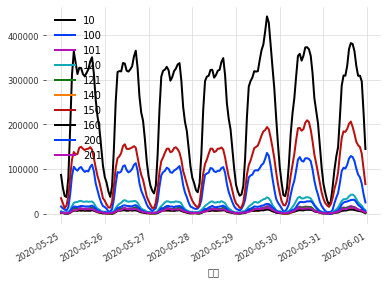

In [47]:
# load model
model = NBEATSModel.load_model("nbeats_5511.pth.tar")
model.predict(n=24*7, series=test_df[:24*7]).plot()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 25it [00:00, ?it/s]


[2022-02-21 00:50:57,576] WARNING | darts.timeseries | Number of components is larger than 10 (35). Plotting only the first 10 components.
[2022-02-21 00:50:57,634] WARNING | darts.timeseries | Number of components is larger than 10 (35). Plotting only the first 10 components.


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


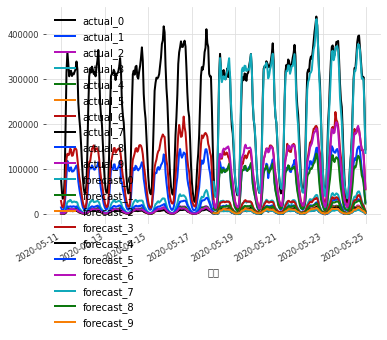

In [48]:
pred_series = model.predict(n=24*7, series=val_df[:24*7])

val_df.plot(label="actual")
pred_series.plot(label="forecast")
plt.legend()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 25it [00:00, ?it/s]


[2022-02-21 00:51:01,740] WARNING | darts.timeseries | Number of components is larger than 10 (35). Plotting only the first 10 components.
[2022-02-21 00:51:01,797] WARNING | darts.timeseries | Number of components is larger than 10 (35). Plotting only the first 10 components.


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


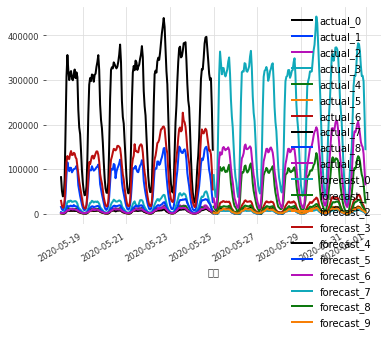

In [49]:
pred_series = model.predict(n=24*7, series=test_df[:24*7])

test_df[:24*7].plot(label="actual")
pred_series.plot(label="forecast")
plt.legend()

In [252]:
pred_df = pred_series.pd_dataframe()
pred_df

component,10,100,101,120,121,140,150,160,200,201,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
날짜,,,,,,,,,,,,,,,,,,,,,
2020-05-25 00:00:00,86623.592790,15889.650962,1311.571799,5090.760767,1166.599257,864.622056,34393.630366,1394.532046,3155.543658,1888.500947,...,1121.328980,2758.828312,3691.794850,3453.959634,1658.188993,4684.184798,706.856810,2087.564910,2013.620110,2197.610685
2020-05-25 01:00:00,57731.173429,11862.033756,1779.797846,3798.957124,1518.788558,1504.958981,23175.817514,1357.814153,1783.511010,1562.866547,...,1381.903083,2088.319577,1834.770462,2475.505116,2188.690741,4218.300351,414.608028,3033.349483,1700.308074,2145.004145
2020-05-25 02:00:00,39395.786797,8840.759130,359.289857,2025.950412,332.012933,748.833313,12239.503242,428.284243,2097.484733,865.914501,...,-233.148525,2126.138762,-842.381474,676.773766,655.303750,1789.271195,828.705851,1266.784267,742.021693,2779.616421
2020-05-25 03:00:00,36920.426928,6910.302485,-209.284060,1989.747229,769.537948,1323.024395,18023.936268,-4.076340,2227.966049,952.327568,...,-677.165851,1971.910896,-930.580846,-51.000388,1185.802802,1155.787598,411.003879,1366.483904,27.074202,166.979625
2020-05-25 04:00:00,80586.355258,13999.724116,143.921798,2873.721485,79.218667,757.315068,38714.390353,455.172054,1490.931526,1933.912162,...,-309.102984,3338.552139,5375.850335,3705.789610,2000.109578,2268.195914,-25.596101,1877.353772,988.022213,1861.120685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00,309132.942785,87590.384592,9491.794818,25666.508893,7558.177982,6766.595349,153379.993367,6002.263726,19514.962029,8699.581596,...,5987.534030,14098.719911,26901.114676,13372.408947,7277.646298,21613.446808,2963.348872,12463.512659,7815.517821,18493.147687
2020-05-31 20:00:00,309445.595874,81162.381782,8244.955468,21712.061692,6851.927697,5412.521360,149417.278749,5419.668751,16109.512491,7359.889961,...,5537.931903,13627.507438,26342.752702,14022.326445,7193.324451,19757.811002,2928.441485,12370.487931,9133.707049,15911.593612
2020-05-31 21:00:00,296691.073143,67247.309991,7979.945177,17719.934563,6179.482001,4912.190157,134335.311395,4679.477212,12513.365729,6549.308827,...,4209.705734,11765.694641,23692.322004,12854.823861,6106.446531,18499.294940,2802.995001,10403.137739,7100.051945,13350.859220


In [254]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)
submission_table.iloc[:,1:] = pred_df.reset_index(drop=True)
submission_table.to_csv('nbeats.csv', index=False)